Explarational data analysis dump

In [2]:
import sys
import zipfile
import os
from pathlib import Path
sys.path.append(str(Path("..").resolve()))


In [3]:
import pandas as pd
import polars as pl
import networkx as nx

from networkx.algorithms import bipartite
import matplotlib.pyplot as plt
from utils import gpn
from objects import *
from sa import GPNOptimizer


In [3]:
# check for optimal graphs from space of all graphs on 9 nodes

all_graphs_upto9n_df = (
    pd.read_csv(r"../../data/generated/all_graphs_9n.csv")
    .assign(max_gpn=lambda df: df.groupby("num_nodes")["gpn_num"].transform("max"))
    .query("gpn_num == max_gpn")
    .drop(columns=["max_gpn", "num_edges"])
    .sort_values(["num_nodes"])
)


In [4]:
all_graphs_upto9n_df


,graph6_encoding,num_nodes,gpn_num
0,@,1,1
1,A_,2,3
2,BW,3,6
3,Bw,3,6
7,C],4,12
16,DFw,5,20
101,EFz_,6,33
340,F?zv_,7,49
353,F?~v_,7,49
5412,G?zVf_,8,74


In [5]:
# search space is limited only to specific class data (bp, cubic, tf)
# display graphs with highest gpn values

graph_class_df = (
    pd.read_csv(r"../../data/generated/gpn_class_data.csv")
    .assign(max_gpn=lambda df: df.groupby("num_nodes")["gpn_num"].transform("max"))
    .query("gpn_num == max_gpn")
    .drop(columns=["max_gpn", "num_edges"])
    .sort_values(["num_nodes"])
    # .to_csv("../../data/generated/opt_gpn_graphs.csv", index=False)
)


In [6]:
graph_class_df


,graph6_encoding,type,num_nodes,gpn_num
0,@,bipartite,1,1
5043,@,triangle-free,1,1
1,A_,bipartite,2,3
5044,A_,triangle-free,2,3
5045,BW,triangle-free,3,6
2,BW,bipartite,3,6
5,C],bipartite,4,12
5048,C],triangle-free,4,12
5052,DFw,triangle-free,5,20
9,DFw,bipartite,5,20


In [7]:
# since there is 11M rows of all connected & simple graphs on 10 nodes, we decided to import this data from internet
# so there is no overhead with graph generation; we deal with calculatoin of gpn values
# file is huge (over Github registry limit, so its zipped at the start) 

with zipfile.ZipFile("../../data/generated/gpn_values_for10n.zip", 'r') as zip_ref:
    zip_ref.extractall("../../data/generated/")


In [8]:
# graph with highest gpn value on 10 nodes, 
# using polars to lazy load this huge file (no need to load whole thing into main memory)
# aka lazy loading is the way to go here

all_graphs_10n_df = (
    pl.scan_csv("../../data/generated/gpn_values_n10.csv")
    .filter(pl.col("gpn_num") == pl.col("gpn_num").max())
    .collect()
)


In [9]:
print(all_graphs_10n_df)


shape: (1, 2)
┌───────────┬─────────┐
│ id        ┆ gpn_num │
│ ---       ┆ ---     │
│ str       ┆ i64     │
╞═══════════╪═════════╡
│ I?BvUqw}? ┆ 151     │
└───────────┴─────────┘


In [10]:
# encoded graphs (graph6 encoding is used to identify simple labeled graph)

opt_graphs = []

for graph in all_graphs_upto9n_df["graph6_encoding"]: 
        opt_graphs.append(graph)

for graph in all_graphs_10n_df["id"]:
        opt_graphs.append(graph)


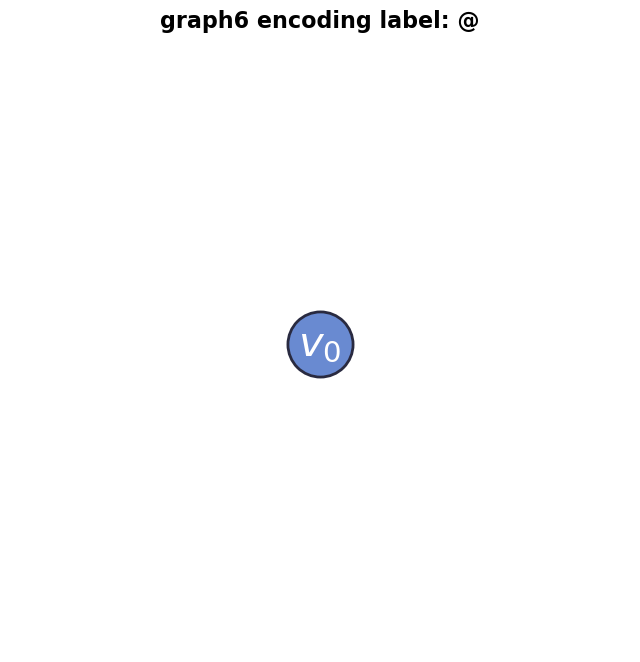

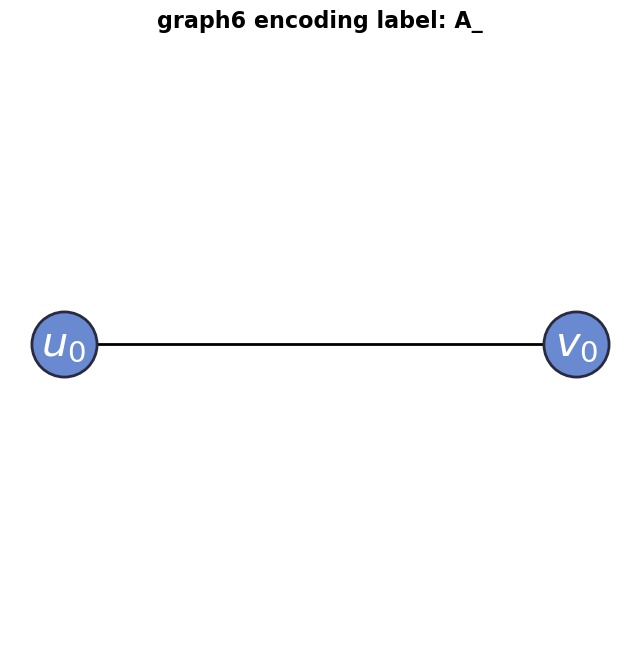

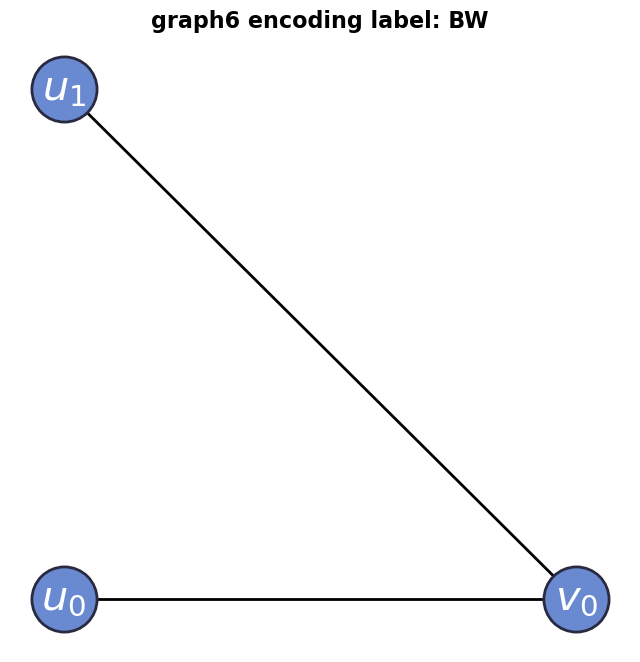

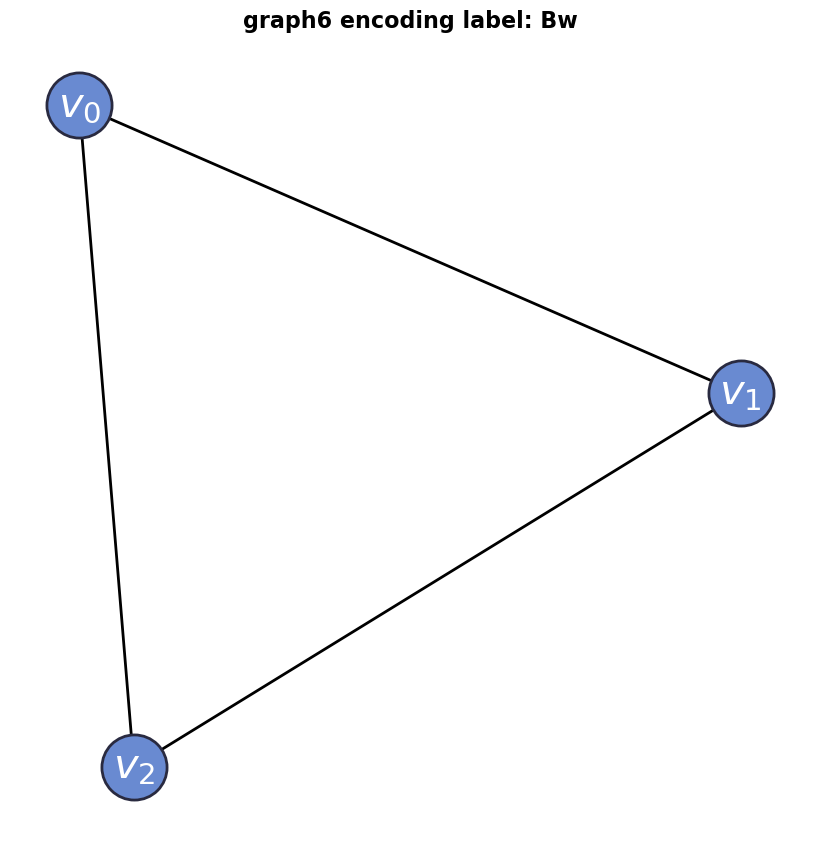

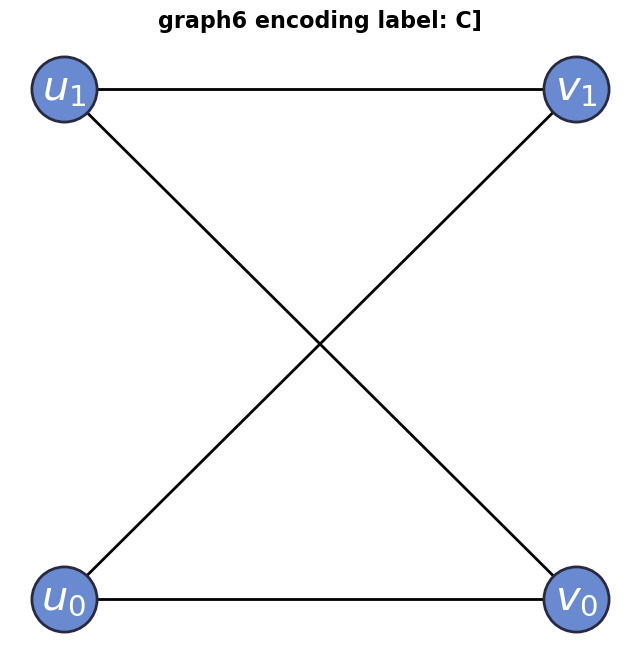

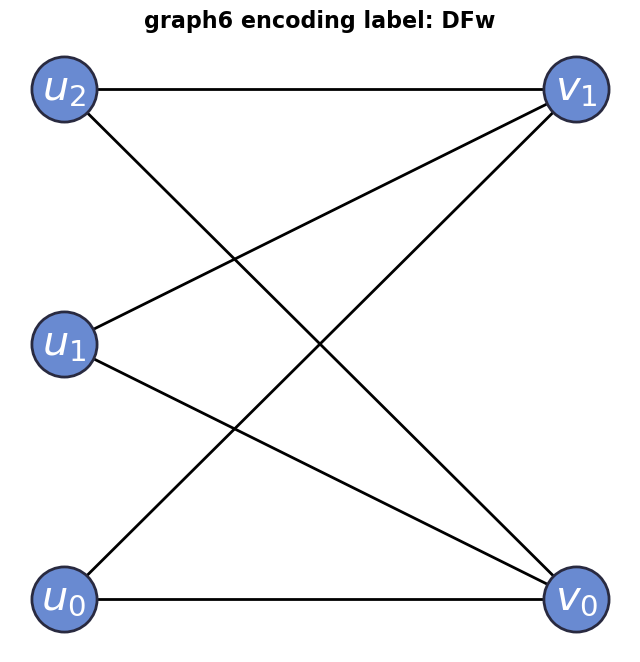

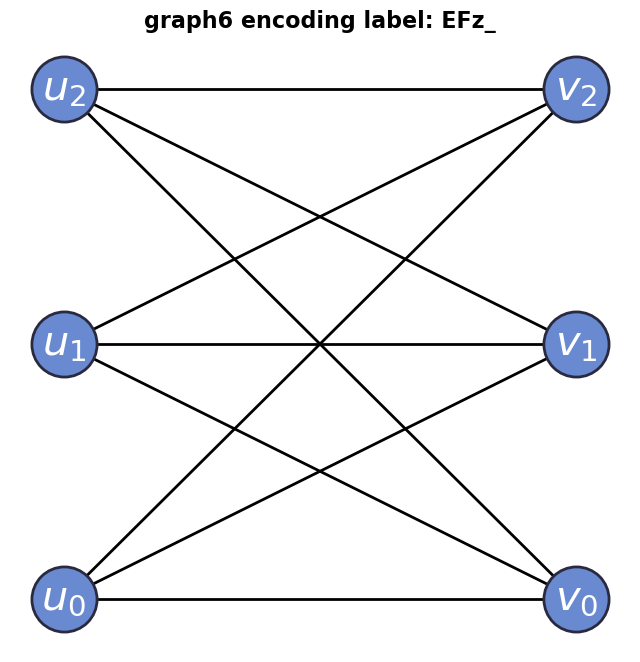

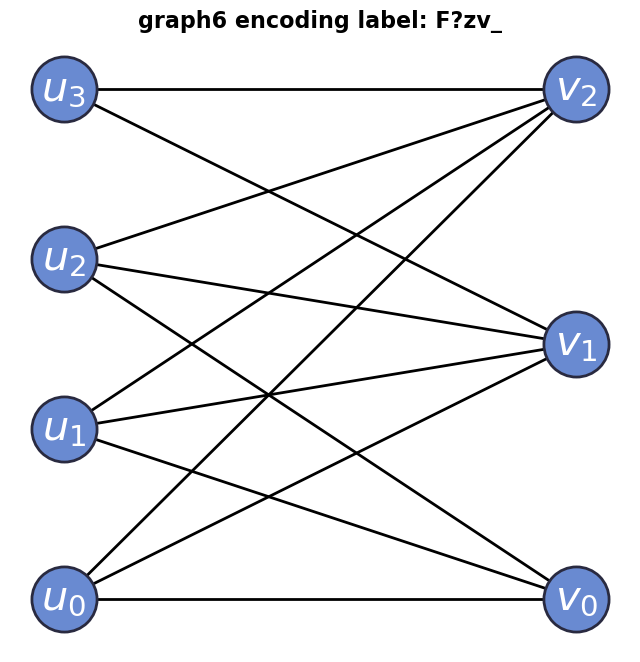

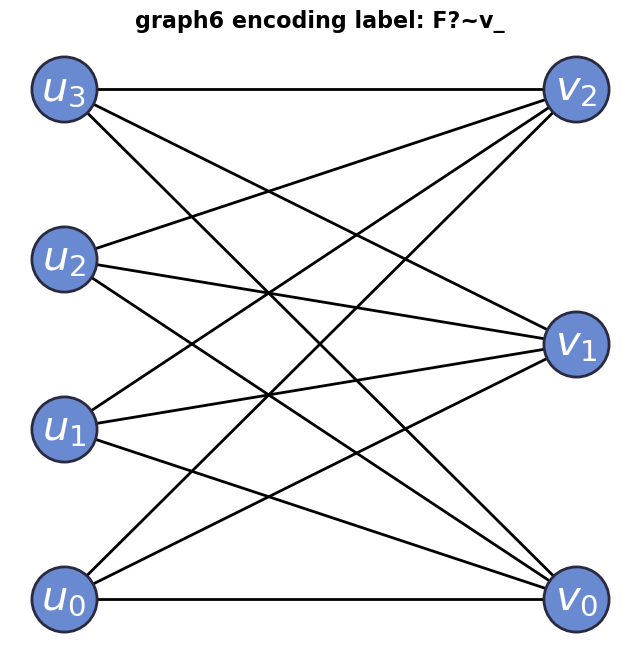

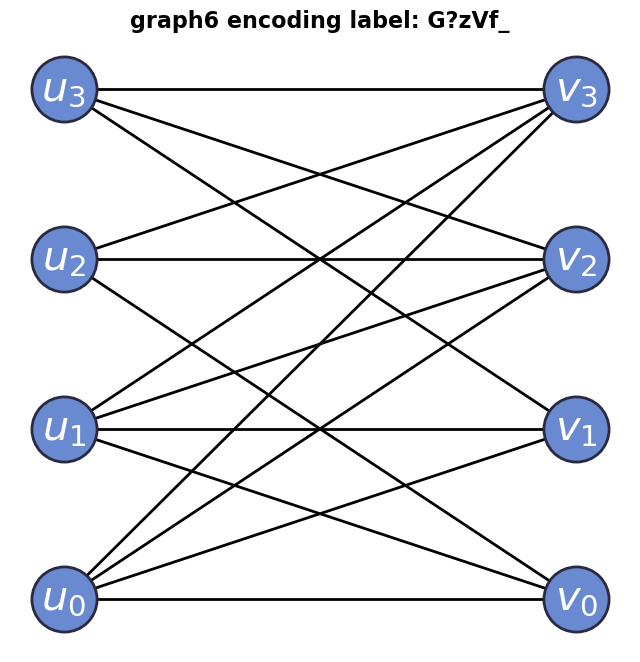

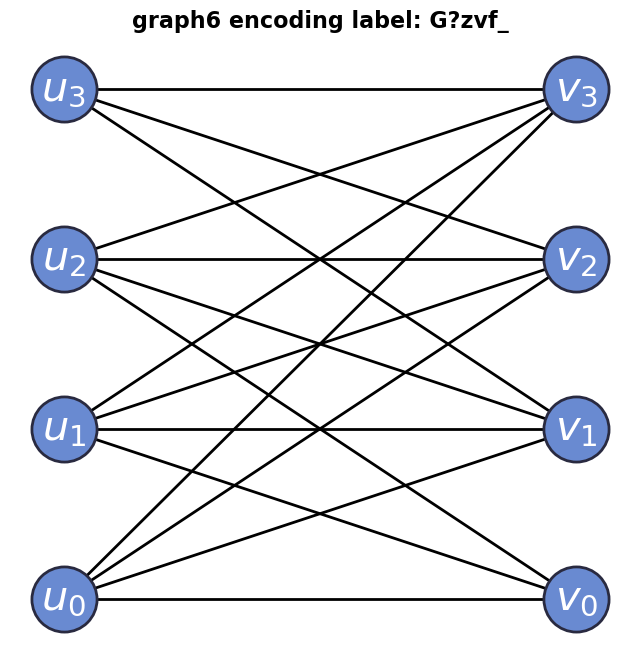

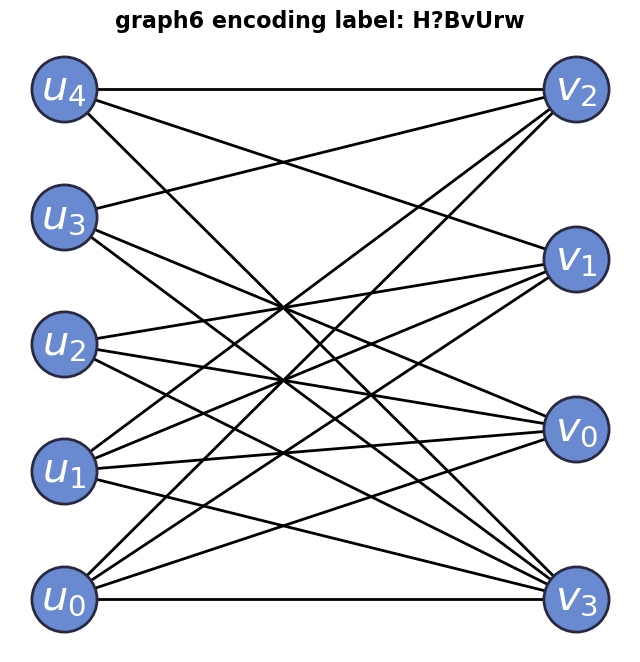

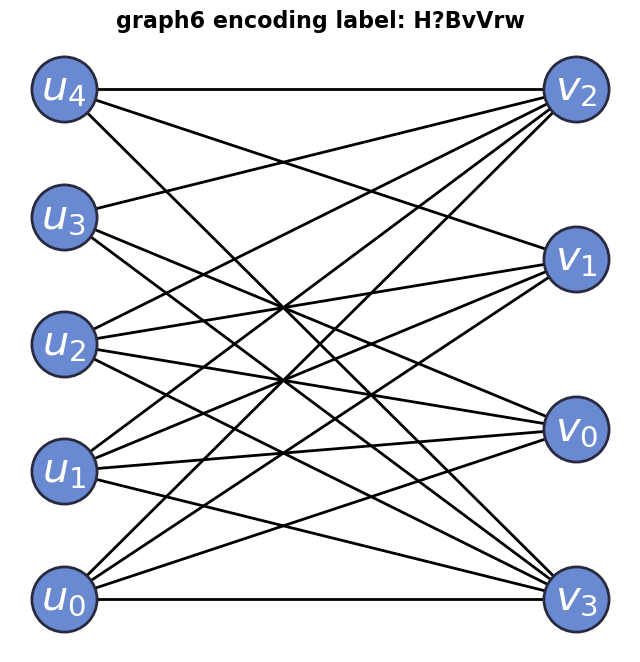

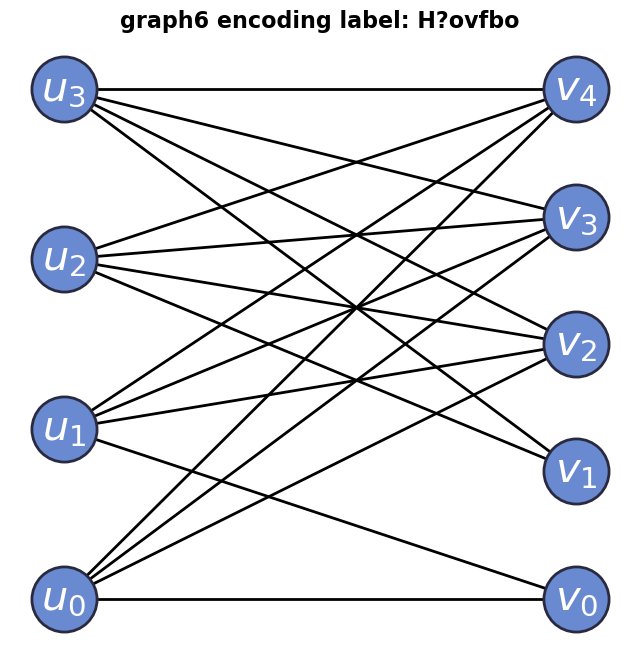

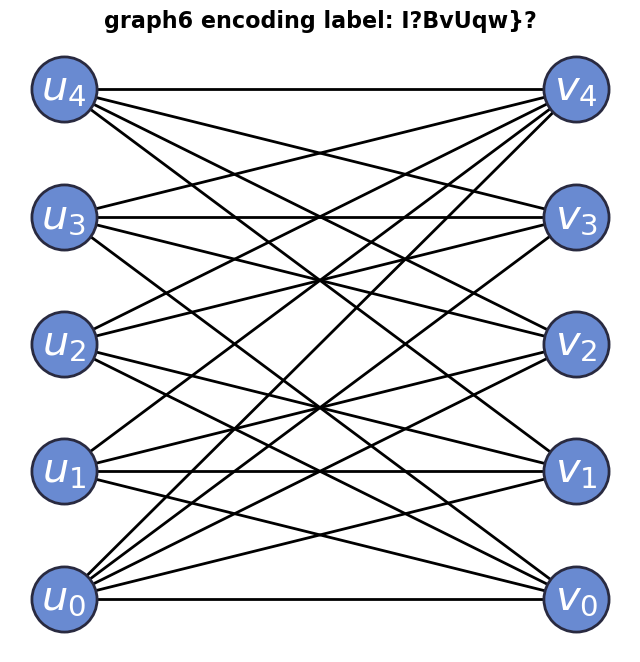

In [12]:
# visualize all extremal graphs that maximise the gpn value

graphs = []
for graph in opt_graphs:
    byte_graph_encoding = graph.encode()
    decoded_graph = nx.from_graph6_bytes(byte_graph_encoding)
    graphs.append(decoded_graph)

for graph in graphs:

    label = (
        nx.to_graph6_bytes(graph, header=False)
        .decode("utf-8")
        .replace("\n", "")
        .replace("\r", "")
    )
    
    if nx.is_bipartite(graph):
        u_set, v_set = nx.bipartite.sets(graph)
        
        labels = {}
        for i, node in enumerate(sorted(u_set)):
            labels[node] = f"$u_{{{i}}}$"
        for i, node in enumerate(sorted(v_set)):
            labels[node] = f"$v_{{{i}}}$"
        
        plt.figure(figsize=(8, 8))
        
        nx.draw_networkx(
            graph,
            pos=nx.bipartite_layout(graph, u_set),
            labels=labels,
            node_color="#698ad1",
            edgecolors="#292a40",
            linewidths=2,
            node_size=2200,
            width=2,
            font_color="white",
            font_size=30
        )

        plt.title(f"graph6 encoding label: {label}", fontweight="bold", fontsize=16)
        plt.axis("off")
        plt.savefig(f"../../docs/figs/opt_graphs/{label}.png", bbox_inches="tight", facecolor="white")

    else:
        plt.figure(figsize=(8, 8))
        
        labels = {}
        for i, node in enumerate(graph.nodes()):
            labels[node] = f"$v_{{{i}}}$"

        nx.draw(
            graph,
            labels=labels,
            node_color="#698ad1",
            edgecolors="#292a40",
            linewidths=2,
            node_size=2200,
            width=2,
            font_color="white",
            font_size=30
        )
        plt.title(f"graph6 encoding label: {label}", fontweight="bold", fontsize=16)
        plt.axis("off")
        plt.savefig(f"../../docs/figs/opt_graphs/{label}.png", bbox_inches="tight", facecolor="white")


In [13]:
# report table preparation (return tex code)

data = []
for graph6_str in opt_graphs:
    graph = nx.from_graph6_bytes(graph6_str.encode())
    
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    is_bipartite = nx.is_bipartite(graph)
    is_cubic = all(degree == 3 for _, degree in graph.degree())
    is_triangle_free = (
        all(nx.triangles(graph, node) == 0 for node in graph.nodes())
        if not nx.is_bipartite(graph)
        else True
    )
    gpn_num = gpn(graph)
    
    data.append([
        graph6_str,
        num_nodes,
        num_edges,
        is_triangle_free,
        is_bipartite,
        is_cubic,
        gpn_num
    ])

report_opt_df = pd.DataFrame(
    data,
    columns=["graph6_id", "num_nodes", "num_edges",  "is_triangle_free", "is_bipartite", "is_cubic", "gpn_num"]
)


In [14]:
report_opt_df


,graph6_id,num_nodes,num_edges,is_triangle_free,is_bipartite,is_cubic,gpn_num
0,@,1,0,True,True,False,1
1,A_,2,1,True,True,False,3
2,BW,3,2,True,True,False,6
3,Bw,3,3,False,False,False,6
4,C],4,4,True,True,False,12
5,DFw,5,6,True,True,False,20
6,EFz_,6,9,True,True,True,33
7,F?zv_,7,11,True,True,False,49
8,F?~v_,7,12,True,True,False,49
9,G?zVf_,8,14,True,True,False,74


In [15]:
map_col = ["is_bipartite", "is_cubic", "is_triangle_free"]
report_opt_df[map_col] = report_opt_df[map_col].map(lambda col: "ja" if col else "ne")
report_opt_df
tex_code = report_opt_df.to_latex(index=False)
print(tex_code)


\begin{tabular}{lrrlllr}
\toprule
graph6_id & num_nodes & num_edges & is_triangle_free & is_bipartite & is_cubic & gpn_num \\
\midrule
@ & 1 & 0 & ja & ja & ne & 1 \\
A_ & 2 & 1 & ja & ja & ne & 3 \\
BW & 3 & 2 & ja & ja & ne & 6 \\
Bw & 3 & 3 & ne & ne & ne & 6 \\
C] & 4 & 4 & ja & ja & ne & 12 \\
DFw & 5 & 6 & ja & ja & ne & 20 \\
EFz_ & 6 & 9 & ja & ja & ja & 33 \\
F?zv_ & 7 & 11 & ja & ja & ne & 49 \\
F?~v_ & 7 & 12 & ja & ja & ne & 49 \\
G?zVf_ & 8 & 14 & ja & ja & ne & 74 \\
G?zvf_ & 8 & 15 & ja & ja & ne & 74 \\
H?BvUrw & 9 & 17 & ja & ja & ne & 105 \\
H?BvVrw & 9 & 18 & ja & ja & ne & 105 \\
H?ovfbo & 9 & 16 & ja & ja & ne & 105 \\
I?BvUqw}? & 10 & 21 & ja & ja & ne & 151 \\
\bottomrule
\end{tabular}



\begin{tabular}{llrrrrrr}
\toprule
 & id & gpn_num & num_nodes & num_edges & is_bipartite & is_cubic & is_triangle_free \\
\midrule
0 & J??E@w{}Fo? & 209 & 11 & 20 & True & False & True \\
\bottomrule
\end{tabular}

\begin{tabular}{llrrrrrr}
\toprule
 & id & gpn_num & num_nodes & num_edges & is_bipartite & is_cubic & is_triangle_free \\
\midrule
0 & K??E@w{}Fo^? & 303 & 12 & 25 & True & False & True \\
\bottomrule
\end{tabular}



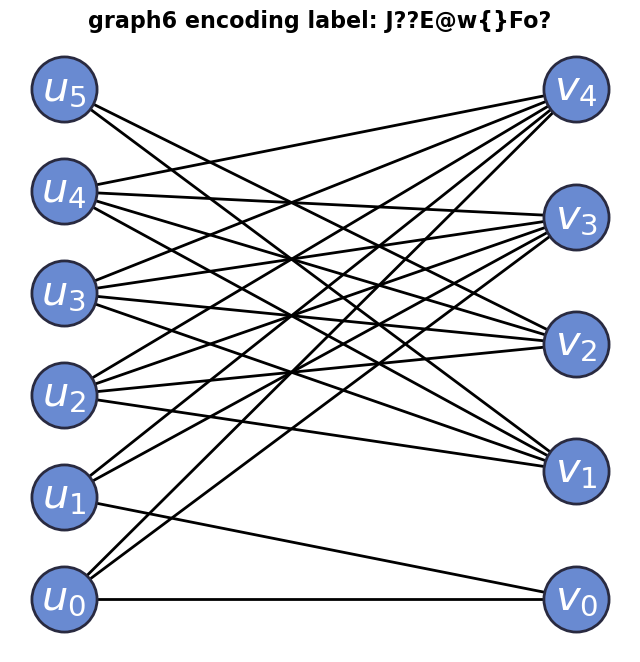

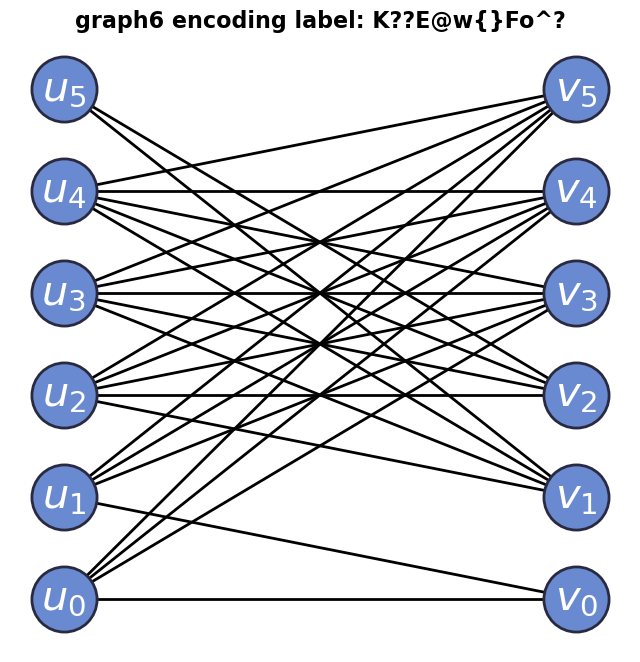

In [42]:
# optimal bipartite graph on 11 and 12 nodes (using hypotesis that bp graps class optimize gpn num)
# in the process, we noticed that balanced bipartite graphs constitute a
# subspace containing graphs with particularly large gpn values (this was final final hypotesis)

for num_nodes in [11, 12]:
    df = (
        pl.scan_csv(f"../../data/generated/bp_graph_data_n{num_nodes}.csv")
        .filter(pl.col("gpn_num") == pl.col("gpn_num").max())
        .with_columns([
            pl.col("id").map_elements(
                lambda g6_str: nx.from_graph6_bytes(g6_str.encode()).number_of_nodes(),
                return_dtype=pl.Int64
            ).alias("num_nodes"),
            
            pl.col("id").map_elements(
                lambda g6_str: nx.from_graph6_bytes(g6_str.encode()).number_of_edges(),
                return_dtype=pl.Int64
            ).alias("num_edges"),
            
            pl.col("id").map_elements(
                lambda g6_str: nx.is_bipartite(nx.from_graph6_bytes(g6_str.encode())),
                return_dtype=pl.Boolean
            ).alias("is_bipartite"),
            
            pl.col("id").map_elements(
                lambda g6_str: all(
                    d == 3 for _, d in nx.from_graph6_bytes(g6_str.encode()).degree()
                ),
                return_dtype=pl.Boolean
            ).alias("is_cubic"),
            
            pl.col("id").map_elements(
                lambda g6_str: (
                    all(nx.triangles(nx.from_graph6_bytes(g6_str.encode()), node) == 0 
                        for node in nx.from_graph6_bytes(g6_str.encode()).nodes())
                    if not nx.is_bipartite(nx.from_graph6_bytes(g6_str.encode()))
                    else True
                ),
                return_dtype=pl.Boolean
            ).alias("is_triangle_free")
        ])
        .collect()
        .to_pandas()
    )

    graph = nx.from_graph6_bytes(df["id"].iloc[0].encode())


    label = (
        nx.to_graph6_bytes(graph, header=False)
        .decode("utf-8")
        .replace("\n", "")
        .replace("\r", "")
    )
    
    if nx.is_bipartite(graph):
        u_set, v_set = nx.bipartite.sets(graph)
        
        labels = {}
        for i, node in enumerate(sorted(u_set)):
            labels[node] = f"$u_{{{i}}}$"
        for i, node in enumerate(sorted(v_set)):
            labels[node] = f"$v_{{{i}}}$"
        
        plt.figure(figsize=(8, 8))
        
        nx.draw_networkx(
            graph,
            pos=nx.bipartite_layout(graph, u_set),
            labels=labels,
            node_color="#698ad1",
            edgecolors="#292a40",
            linewidths=2,
            node_size=2200,
            width=2,
            font_color="white",
            font_size=30
        )

        plt.title(f"graph6 encoding label: {label}", fontweight="bold", fontsize=16)
        plt.axis("off")
        plt.savefig(f"../../docs/figs/opt_graphs/opt_graph_{num_nodes}.png", bbox_inches="tight", facecolor="white")

    print(df.to_latex())


In [25]:
df = (
    pl.scan_csv(f"../../data/generated/bp_graph_data_n{i}.csv")
    .filter(pl.col("gpn_num") == pl.col("gpn_num").max())
    .collect()
    .to_pandas()
)
a = df["id"]
a


0    J??E@w{}Fo?
Name: id, dtype: object

In [ ]:
# bipartite graphs that minimize gpn value are so called Star graphs (completely biparite graphs on n-1 nodes)
# we wanted to check for those for further use in SA (lol there were not used at all)

min_gpn_cb_graphs = (
    pd.read_csv(r"../../data/generated/all_graphs_9n.csv")
    .assign(
        is_complete_bipartite=lambda df: df["graph6_encoding"].apply(
            lambda graph6_str: (
                bipartite.is_bipartite(nx.from_graph6_bytes(graph6_str.encode())) and
                all(
                    nx.from_graph6_bytes(graph6_str.encode()).has_edge(u, v)
                    for u in bipartite.sets(nx.from_graph6_bytes(graph6_str.encode()))[0]
                    for v in bipartite.sets(nx.from_graph6_bytes(graph6_str.encode()))[1]
                )
            )
        ),
        min_gpn=lambda df: df.groupby("num_nodes")["gpn_num"].transform("min"),
        num_nodes=lambda df: df["num_nodes"],
        num_edges=lambda df: df["num_edges"]
    )
    .query("gpn_num == min_gpn")
    .query("is_complete_bipartite == True")
    .drop(columns=["min_gpn"])
    .sort_values(["num_nodes"])
)


In [16]:
min_gpn_cb_graphs # star graphs minimeze gpn and each star graph is complete bipartite aka K_{{n-1}, 1} (makes sense since star graphs are trees)


,graph6_encoding,num_nodes,num_edges,gpn_num,is_complete_bipartite
0,@,1,0,1,True
1,A_,2,1,3,True
2,BW,3,2,6,True
4,CF,4,3,10,True
10,D?{,5,4,15,True
31,E?Bw,6,5,21,True
143,F??Fw,7,6,28,True
996,G???F{,8,7,36,True
12113,H????B~,9,8,45,True


In [ ]:
# hypotesis: complete graphs minimize gpn invariant
# note; minimal possible gpn for given n is: \binom{n}{2} (trees)

for n in range(1, 21):
    K_n = nx.complete_graph(n)
    print(f"K_{n}: expected gpn = {n + n*(n-1)//2}, actual gpn: {gpn(K_n)}")


K_1: expected gpn = 1, actual gpn: 1
K_2: expected gpn = 3, actual gpn: 3
K_3: expected gpn = 6, actual gpn: 6
K_4: expected gpn = 10, actual gpn: 10
K_5: expected gpn = 15, actual gpn: 15
K_6: expected gpn = 21, actual gpn: 21
K_7: expected gpn = 28, actual gpn: 28
K_8: expected gpn = 36, actual gpn: 36
K_9: expected gpn = 45, actual gpn: 45
K_10: expected gpn = 55, actual gpn: 55
K_11: expected gpn = 66, actual gpn: 66
K_12: expected gpn = 78, actual gpn: 78
K_13: expected gpn = 91, actual gpn: 91
K_14: expected gpn = 105, actual gpn: 105
K_15: expected gpn = 120, actual gpn: 120
K_16: expected gpn = 136, actual gpn: 136
K_17: expected gpn = 153, actual gpn: 153
K_18: expected gpn = 171, actual gpn: 171
K_19: expected gpn = 190, actual gpn: 190
K_20: expected gpn = 210, actual gpn: 210


In [ ]:
# random search for balance bipartite graph on 10 nodes
# finds opt graph solution in seconds (since we wastly lowered searched space)

best_score = 0
best_graph = None

for i in range(1000):
    graph_obj = RandomBalancedBipartiteGraph(num_nodes=10, edge_probability=random.uniform(0.3, 0.9))
    score = gpn(graph_obj.graph)
    
    if score > best_score:
        best_score = score
        best_graph = graph_obj
        print(f"Iteration {i}: set new best gpn score = {best_score:.6f}")


Iteration 0: set new best gpn score = 70.000000
Iteration 1: set new best gpn score = 145.000000
Iteration 34: set new best gpn score = 150.000000
Iteration 687: set new best gpn score = 151.000000


In [ ]:
# random search across balanced biparitte graphs 
# this narrowing of the search space was game changing

num_iterations = 1000
best_score = 0
best_graph_obj = None

data = []

for num_nodes in range(11, 31):
    for i in range(num_iterations):
        edge_prob = random.uniform(0.3, 0.9)
        graph_obj = RandomBalancedBipartiteGraph(num_nodes=num_nodes, edge_probability=edge_prob)
        graph = graph_obj.graph
        score = gpn(graph)

        if score > best_score:
            best_score = score
            best_graph_obj = graph_obj
            print(f"iteration {i}, num_nodes={num_nodes}: new best gpn score = {best_score:.6f}")

    label = (
        nx.to_graph6_bytes(best_graph_obj.graph, header=False)
        .decode("utf-8")
        .replace("\n", "")
        .replace("\r", "")
    )

    gpn_value = best_score
    num_nodes_best = best_graph_obj.graph.number_of_nodes()
    num_edges_best = best_graph_obj.graph.number_of_edges()

    data.append({
        "graph6_label": label,
        "num_nodes": num_nodes_best,
        "num_edges": num_edges_best,
        "gpn_score": gpn_value,
    })

random_search_balanced_bp_df = pd.DataFrame(data)


iteration 0, num_nodes=11: new best gpn score = 106.000000
iteration 2, num_nodes=11: new best gpn score = 191.000000
iteration 34, num_nodes=11: new best gpn score = 195.000000
iteration 40, num_nodes=11: new best gpn score = 199.000000
iteration 311, num_nodes=11: new best gpn score = 204.000000
iteration 4, num_nodes=12: new best gpn score = 233.000000
iteration 6, num_nodes=12: new best gpn score = 253.000000
iteration 8, num_nodes=12: new best gpn score = 263.000000
iteration 53, num_nodes=12: new best gpn score = 267.000000
iteration 256, num_nodes=12: new best gpn score = 271.000000
iteration 0, num_nodes=13: new best gpn score = 287.000000
iteration 1, num_nodes=13: new best gpn score = 299.000000
iteration 2, num_nodes=13: new best gpn score = 337.000000
iteration 67, num_nodes=13: new best gpn score = 339.000000
iteration 77, num_nodes=13: new best gpn score = 343.000000
iteration 95, num_nodes=13: new best gpn score = 344.000000
iteration 115, num_nodes=13: new best gpn scor

In [ ]:
random_search_balanced_bp_df


,graph6_label,num_nodes,num_edges,gpn_score
0,J?BlvrouFo?,11,26,204
1,K??F~X{|Ew]_,12,31,271
2,L??Ezz{nFg\?n?,13,35,354
3,M???Dy}vfk^O~_z_?,14,42,461
4,N???B~]{fwNo~_|?\o?,15,47,575
5,O????Az^V{Zwno|o^oF}?,16,55,721
6,P????@vvv}^WzovONwFk?no?,17,61,899
7,Q??????~}~Nk^wzo]wFL?}_B|_?,18,66,1081
8,R??????zvl^[vw~wF{Ez?~_@z?Fp??,19,72,1312
9,S???????Evn}|kl{\uD|_}{BnOFz_F~_?,20,85,1584


In [29]:
# using random search to determine itial state and then perform neighbour search with SA (values get better)
num_nodes = 12
best_score = 0
best_graph = None

for i in range(1000):
    graph_obj = RandomBalancedBipartiteGraph(num_nodes=num_nodes, edge_probability=random.uniform(0.3, 0.9))
    score = gpn(graph_obj.graph)
    
    if score > best_score:
        best_score = score
        best_graph = graph_obj
        print(f"Iteration {i}: set new best gpn score = {best_score:.6f}")
        
opt = GPNOptimizer(best_graph.graph)

opt.steps = 5000
opt.Tmax = 5.0
opt.Tmin = 1e-3

best_graph, best_energy = opt.anneal()

print("final GPN:", gpn(best_graph))


Iteration 0: set new best gpn score = 264.000000
Iteration 69: set new best gpn score = 267.000000
Iteration 195: set new best gpn score = 268.000000
Iteration 259: set new best gpn score = 274.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100       -282.00    20.00%     0.00%     0:00:12     0:00:00

final GPN: 282


In [33]:
# perform SA for graphs up to 30 nodes
import random
import pandas as pd
import networkx as nx

num_iterations = 1000
data = []

for num_nodes in range(11, 31):

    print(f"\n=== num_nodes = {num_nodes} ===")

    best_score = 0
    best_graph = None

    # random search (used in SA as initial state)
    for i in range(num_iterations):
        edge_prob = random.uniform(0.3, 0.9)
        graph_obj = RandomBalancedBipartiteGraph(
            num_nodes=num_nodes,
            edge_probability=edge_prob
        )
        graph = graph_obj.graph
        score = gpn(graph)

        if score > best_score:
            best_score = score
            best_graph = graph
            print(
                f"random iter {i}: new best gpn = {best_score:.6f}"
            )

    # SA optimisation
    opt = GPNOptimizer(best_graph)

    opt.steps = 5000
    opt.Tmax = 5.0
    opt.Tmin = 1e-3

    best_graph_sa, best_energy = opt.anneal()

    label = (
        nx.to_graph6_bytes(best_graph_sa, header=False)
        .decode("utf-8")
        .replace("\n", "")
        .replace("\r", "")
    )

    data.append({
        "graph6_label": label,
        "num_nodes": best_graph_sa.number_of_nodes(),
        "num_edges": best_graph_sa.number_of_edges(),
        "gpn_score": gpn(best_graph_sa),
    })


sa_balanced_bp_df = pd.DataFrame(data)

sa_balanced_bp_df.to_csv(r"../../data/generated/sa_opt_larger_nodes.csv")



=== num_nodes = 11 ===
random iter 0: new best gpn = 66.000000
random iter 1: new best gpn = 148.000000
random iter 2: new best gpn = 174.000000
random iter 5: new best gpn = 188.000000
random iter 9: new best gpn = 190.000000
random iter 16: new best gpn = 193.000000
random iter 27: new best gpn = 197.000000
random iter 131: new best gpn = 204.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100       -206.00    40.00%     0.00%     0:00:09     0:00:00


=== num_nodes = 12 ===
random iter 0: new best gpn = 98.000000
random iter 1: new best gpn = 137.000000
random iter 2: new best gpn = 146.000000
random iter 3: new best gpn = 250.000000
random iter 15: new best gpn = 258.000000
random iter 19: new best gpn = 261.000000
random iter 36: new best gpn = 271.000000
random iter 445: new best gpn = 272.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100       -267.00    16.00%     0.00%     0:00:11     0:00:00


=== num_nodes = 13 ===
random iter 0: new best gpn = 337.000000
random iter 15: new best gpn = 341.000000
random iter 26: new best gpn = 350.000000
random iter 314: new best gpn = 351.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100       -364.00    24.00%     0.00%     0:00:14     0:00:00


=== num_nodes = 14 ===
random iter 0: new best gpn = 430.000000
random iter 5: new best gpn = 443.000000
random iter 38: new best gpn = 446.000000
random iter 42: new best gpn = 452.000000
random iter 346: new best gpn = 455.000000
random iter 482: new best gpn = 458.000000
random iter 537: new best gpn = 461.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100       -476.00    28.00%     0.00%     0:00:20     0:00:00


=== num_nodes = 15 ===
random iter 0: new best gpn = 555.000000
random iter 10: new best gpn = 559.000000
random iter 67: new best gpn = 563.000000
random iter 86: new best gpn = 567.000000
random iter 498: new best gpn = 573.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining


random iter 966: new best gpn = 578.000000


     0.00100       -594.00    36.00%     0.00%     0:00:22     0:00:00


=== num_nodes = 16 ===
random iter 0: new best gpn = 302.000000
random iter 2: new best gpn = 618.000000
random iter 5: new best gpn = 684.000000
random iter 7: new best gpn = 698.000000
random iter 39: new best gpn = 729.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100       -744.00    26.00%     0.00%     0:00:29     0:00:00


=== num_nodes = 17 ===
random iter 0: new best gpn = 566.000000
random iter 1: new best gpn = 809.000000
random iter 5: new best gpn = 850.000000
random iter 28: new best gpn = 872.000000
random iter 156: new best gpn = 886.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100       -912.00    20.00%     0.00%     0:00:33     0:00:00


=== num_nodes = 18 ===
random iter 0: new best gpn = 1077.000000
random iter 145: new best gpn = 1090.000000
random iter 452: new best gpn = 1106.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -1122.00    28.00%     0.00%     0:00:39     0:00:00


=== num_nodes = 19 ===
random iter 0: new best gpn = 1209.000000
random iter 4: new best gpn = 1262.000000
random iter 15: new best gpn = 1263.000000
random iter 32: new best gpn = 1286.000000
random iter 79: new best gpn = 1301.000000
random iter 100: new best gpn = 1314.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -1353.00    34.00%     0.00%     0:00:46     0:00:00


=== num_nodes = 20 ===
random iter 0: new best gpn = 1522.000000
random iter 23: new best gpn = 1547.000000
random iter 74: new best gpn = 1559.000000
random iter 243: new best gpn = 1563.000000
random iter 247: new best gpn = 1574.000000
random iter 328: new best gpn = 1580.000000
random iter 609: new best gpn = 1592.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -1640.00    22.00%     0.00%     0:00:54     0:00:00


=== num_nodes = 21 ===
random iter 0: new best gpn = 1387.000000
random iter 1: new best gpn = 1551.000000
random iter 3: new best gpn = 1780.000000
random iter 9: new best gpn = 1787.000000
random iter 10: new best gpn = 1798.000000
random iter 16: new best gpn = 1808.000000
random iter 28: new best gpn = 1826.000000
random iter 176: new best gpn = 1866.000000
random iter 210: new best gpn = 1887.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -1947.00    20.00%     0.00%     0:01:03     0:00:00


=== num_nodes = 22 ===
random iter 0: new best gpn = 681.000000
random iter 1: new best gpn = 1976.000000
random iter 6: new best gpn = 2140.000000
random iter 17: new best gpn = 2151.000000
random iter 29: new best gpn = 2224.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -2321.00    24.00%     0.00%     0:01:14     0:00:00


=== num_nodes = 23 ===
random iter 0: new best gpn = 2404.000000
random iter 1: new best gpn = 2469.000000
random iter 26: new best gpn = 2511.000000
random iter 72: new best gpn = 2551.000000
random iter 132: new best gpn = 2572.000000
random iter 156: new best gpn = 2577.000000
random iter 226: new best gpn = 2579.000000
random iter 273: new best gpn = 2610.000000
random iter 341: new best gpn = 2631.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -2708.00    42.00%     0.00%     0:01:26     0:00:00


=== num_nodes = 24 ===
random iter 0: new best gpn = 1670.000000
random iter 2: new best gpn = 2651.000000
random iter 3: new best gpn = 2818.000000
random iter 4: new best gpn = 2909.000000
random iter 13: new best gpn = 2947.000000
random iter 26: new best gpn = 2973.000000
random iter 38: new best gpn = 2974.000000
random iter 47: new best gpn = 3008.000000
random iter 60: new best gpn = 3045.000000
random iter 767: new best gpn = 3048.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -3168.00    18.00%     0.00%     0:01:39     0:00:00


=== num_nodes = 25 ===
random iter 0: new best gpn = 2774.000000
random iter 2: new best gpn = 3268.000000
random iter 5: new best gpn = 3347.000000
random iter 8: new best gpn = 3391.000000
random iter 12: new best gpn = 3407.000000
random iter 19: new best gpn = 3465.000000
random iter 20: new best gpn = 3494.000000
random iter 239: new best gpn = 3521.000000
random iter 438: new best gpn = 3524.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -3664.00    26.00%     0.00%     0:01:53     0:00:00


=== num_nodes = 26 ===
random iter 0: new best gpn = 3548.000000
random iter 8: new best gpn = 3857.000000
random iter 9: new best gpn = 3858.000000
random iter 12: new best gpn = 3874.000000
random iter 23: new best gpn = 3882.000000
random iter 25: new best gpn = 3970.000000
random iter 56: new best gpn = 3981.000000
random iter 67: new best gpn = 4065.000000
random iter 248: new best gpn = 4070.000000
random iter 419: new best gpn = 4079.000000
random iter 624: new best gpn = 4091.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -4239.00    26.00%     0.00%     0:02:19     0:00:00


=== num_nodes = 27 ===
random iter 0: new best gpn = 3388.000000
random iter 2: new best gpn = 4565.000000
random iter 39: new best gpn = 4608.000000
random iter 77: new best gpn = 4659.000000
random iter 315: new best gpn = 4678.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -4863.00    30.00%     0.00%     0:02:22     0:00:00


=== num_nodes = 28 ===
random iter 0: new best gpn = 3931.000000
random iter 2: new best gpn = 5204.000000
random iter 3: new best gpn = 5219.000000
random iter 12: new best gpn = 5281.000000
random iter 41: new best gpn = 5294.000000
random iter 47: new best gpn = 5336.000000
random iter 60: new best gpn = 5367.000000
random iter 211: new best gpn = 5423.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -5586.00    28.00%     0.00%     0:02:59     0:00:00


=== num_nodes = 29 ===
random iter 0: new best gpn = 3469.000000
random iter 1: new best gpn = 5882.000000
random iter 5: new best gpn = 5911.000000
random iter 54: new best gpn = 5958.000000
random iter 57: new best gpn = 6009.000000
random iter 60: new best gpn = 6049.000000
random iter 283: new best gpn = 6056.000000
random iter 367: new best gpn = 6112.000000
random iter 611: new best gpn = 6137.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -6343.00    20.00%     0.00%     0:03:19     0:00:00


=== num_nodes = 30 ===
random iter 0: new best gpn = 2618.000000
random iter 1: new best gpn = 6029.000000
random iter 2: new best gpn = 6483.000000
random iter 7: new best gpn = 6649.000000
random iter 24: new best gpn = 6773.000000
random iter 36: new best gpn = 6781.000000
random iter 88: new best gpn = 6841.000000
random iter 186: new best gpn = 6849.000000
random iter 248: new best gpn = 6859.000000
random iter 390: new best gpn = 6881.000000
random iter 638: new best gpn = 6967.000000


 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     0.00100      -7230.00    30.00%     0.00%     0:03:31     0:00:00

In [34]:
sa_balanced_bp_df


,graph6_label,num_nodes,num_edges,gpn_score
0,J?BZtrw{FO?,11,25,206
1,K??D~zk~FoZ_,12,32,272
2,L??Fvj[~FWV_^?,13,36,364
3,M???D~u}f[Zo^_~??,14,42,476
4,N???E~m}d{\o|_~?No?,15,48,594
5,O????Bvmv]Vo~OvoNwFs?,16,53,744
6,P????BVvvu^G|O~_VwF]?^o?,17,60,912
7,Q??????|}|V{zWvo^gFt?^wBj_?,18,66,1122
8,R??????}vjJ{ngvW^SFm?zwA~_B~??,19,73,1353
9,S???????B~zy~g}[]uFN_v[AnoF}?Dv_?,20,81,1640


In [ ]:
# check for extermal graphs from space of all cubic graphs

extremal_cubic_graphs = (
    pd.concat(
        [
            pd.read_csv(r"../../data/generated/cubic_graphs_upto18.csv"),
            pd.read_csv(r"../../data/generated/cubic_graphs_on20_nodes.csv"),
        ],
        ignore_index=True,
    )
    .loc[lambda df: df["gpn_num"].eq(df.groupby("num_nodes")["gpn_num"].transform("max"))]
    .assign(graph=lambda df: df["graph6_encoding"].map(lambda s: nx.from_graph6_bytes(s.encode())))
    .assign(
        is_bipartite=lambda df: df["graph"].map(nx.is_bipartite),
        is_cubic=lambda df: df["graph"].map(lambda G: all(d == 3 for _, d in G.degree())),
        is_triangle_free=lambda df: df["graph"].map(lambda G: sum(nx.triangles(G).values()) == 0),
    )
    .drop(columns=["graph", "Unnamed: 0", "type"], errors="ignore")
    .sort_values("num_nodes")
    [["graph6_encoding", "num_nodes", "num_edges", "is_triangle_free", "is_bipartite", "is_cubic","gpn_num"]]
)


In [5]:
extremal_cubic_graphs


,graph6_encoding,num_nodes,num_edges,is_triangle_free,is_bipartite,is_cubic,gpn_num
0,C~,4,6,False,False,True,10
1,EFz_,6,9,True,True,True,33
3,G?zTb_,8,12,True,True,True,68
9,I?Bcu`gM?,10,15,True,True,True,95
29,K??FEagT@WB_,12,18,True,True,True,162
223,M??CBAQa_wB_X?WO?,14,21,False,False,True,221
1329,O???C@_cSaB_B_B_KOB@?,16,24,False,False,True,420
9799,Q????A?WC`R?EGB_?w?M?WO@_O?,18,27,False,False,True,594
92331,S??????_B?QAaCF?B_?M??w?B_B@?B?O?,20,30,False,False,True,938


In [6]:
map_col = ["is_bipartite", "is_cubic", "is_triangle_free"]
extremal_cubic_graphs[map_col] = extremal_cubic_graphs[map_col].map(lambda col: "ja" if col else "ne")
tex_code = extremal_cubic_graphs.to_latex(index=False)
print(tex_code)


\begin{tabular}{lrrlllr}
\toprule
graph6_encoding & num_nodes & num_edges & is_triangle_free & is_bipartite & is_cubic & gpn_num \\
\midrule
C~ & 4 & 6 & ne & ne & ja & 10 \\
EFz_ & 6 & 9 & ja & ja & ja & 33 \\
G?zTb_ & 8 & 12 & ja & ja & ja & 68 \\
I?Bcu`gM? & 10 & 15 & ja & ja & ja & 95 \\
K??FEagT@WB_ & 12 & 18 & ja & ja & ja & 162 \\
M??CBAQa_wB_X?WO? & 14 & 21 & ne & ne & ja & 221 \\
O???C@_cSaB_B_B_KOB@? & 16 & 24 & ne & ne & ja & 420 \\
Q????A?WC`R?EGB_?w?M?WO@_O? & 18 & 27 & ne & ne & ja & 594 \\
S??????_B?QAaCF?B_?M??w?B_B@?B?O? & 20 & 30 & ne & ne & ja & 938 \\
\bottomrule
\end{tabular}



In [ ]:
graph_counts = (
    pd.concat(
        [
            pd.read_csv(r"../../data/generated/cubic_graphs_upto18.csv"),
            pd.read_csv(r"../../data/generated/cubic_graphs_on20_nodes.csv"),
        ],
        ignore_index=True,
    )
    .groupby("num_nodes")
    .size()
    .reset_index(name="num_graphs")
)

print(graph_counts)


   num_nodes  num_graphs
0          4           1
1          6           2
2          8           5
3         10          19
4         12          85
5         14         509
6         16        4060
7         18       41301
8         20      510489


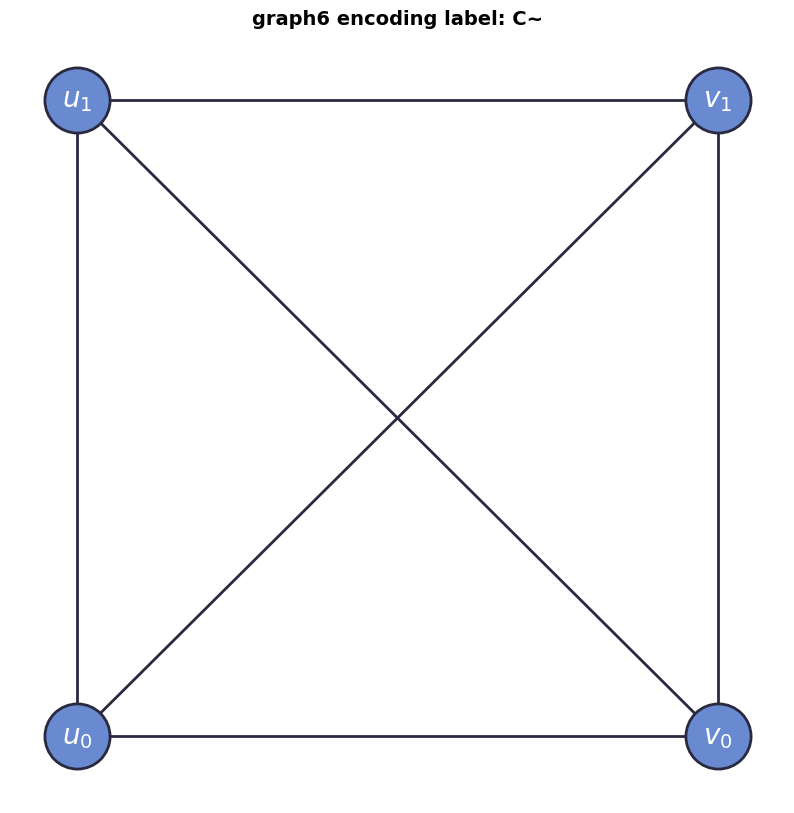

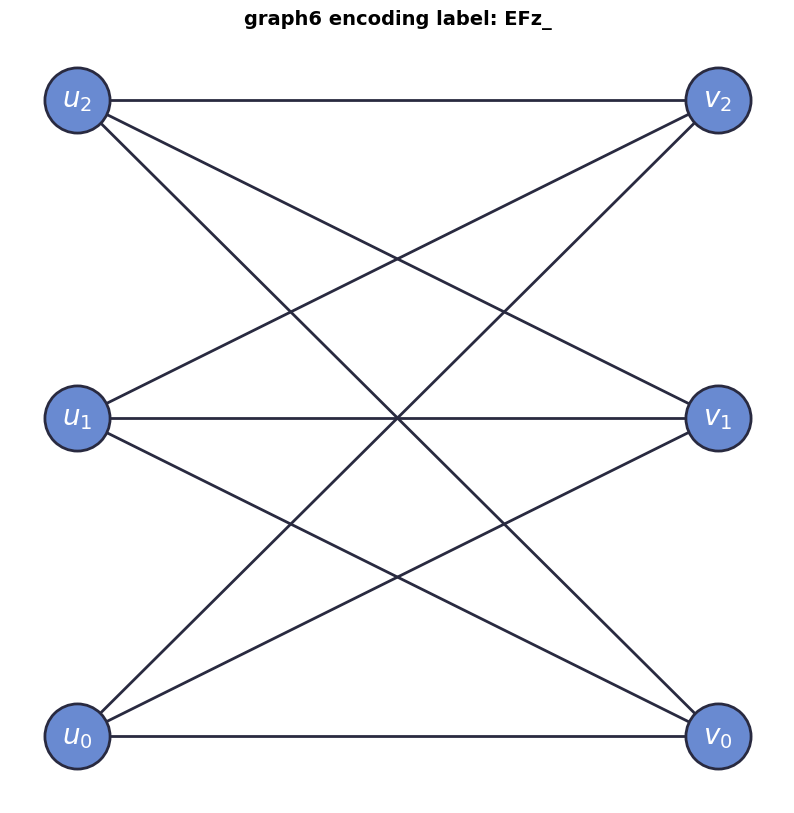

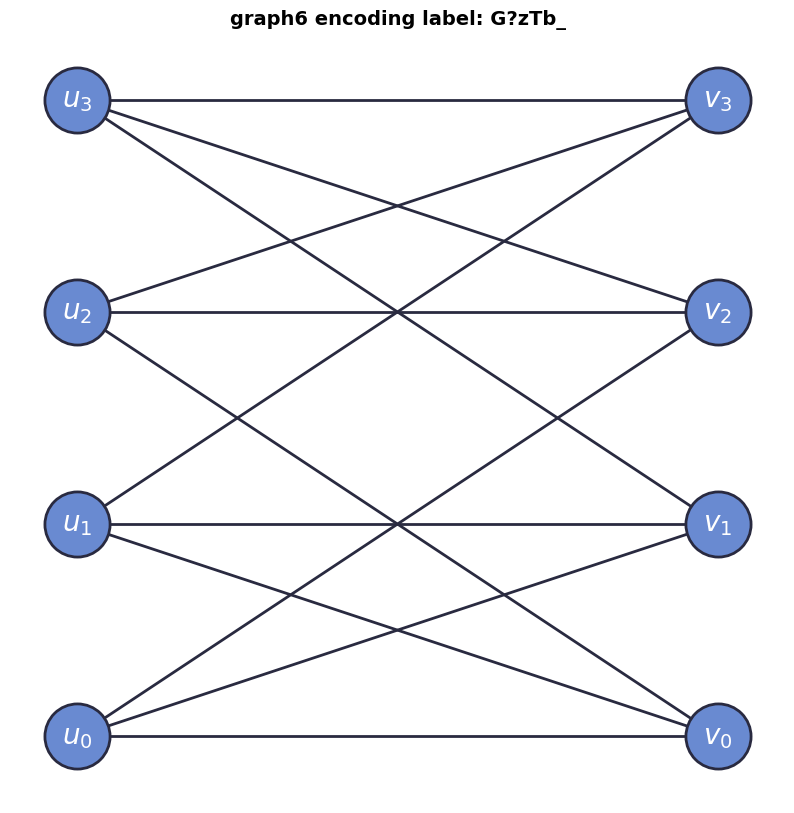

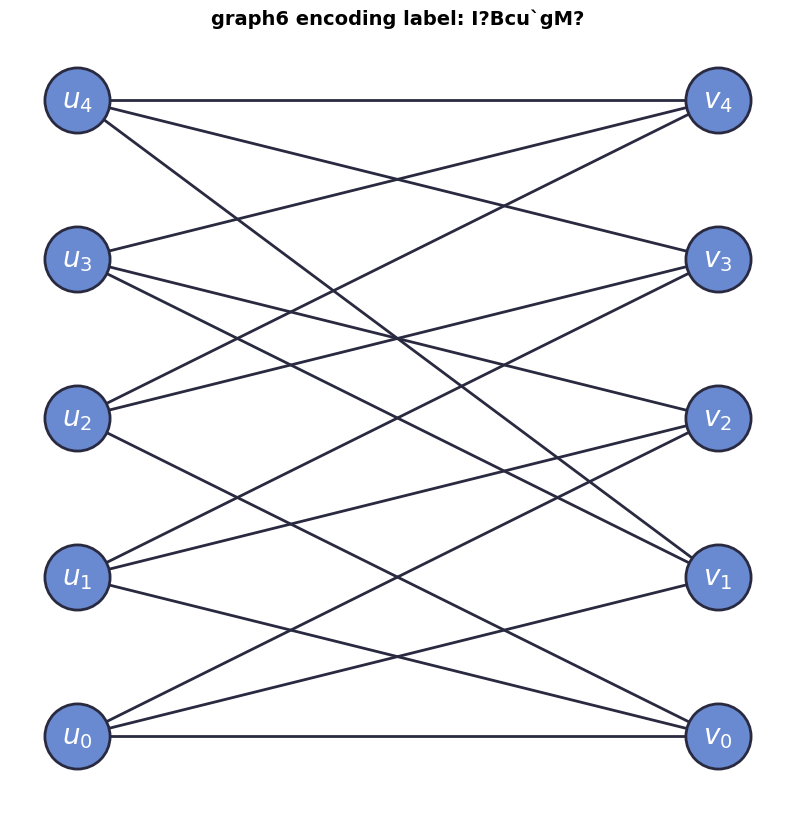

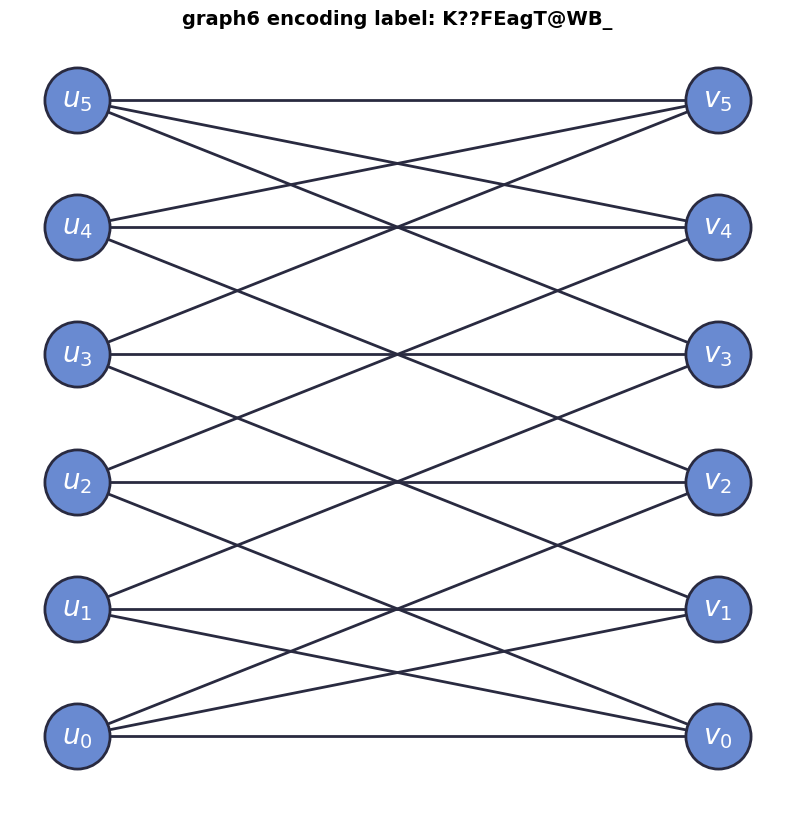

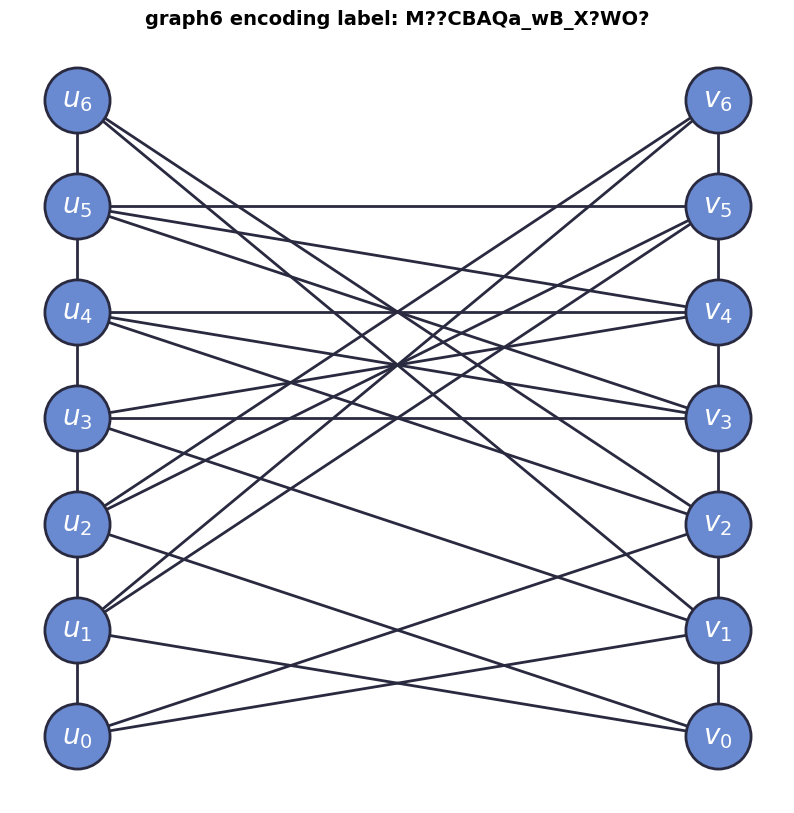

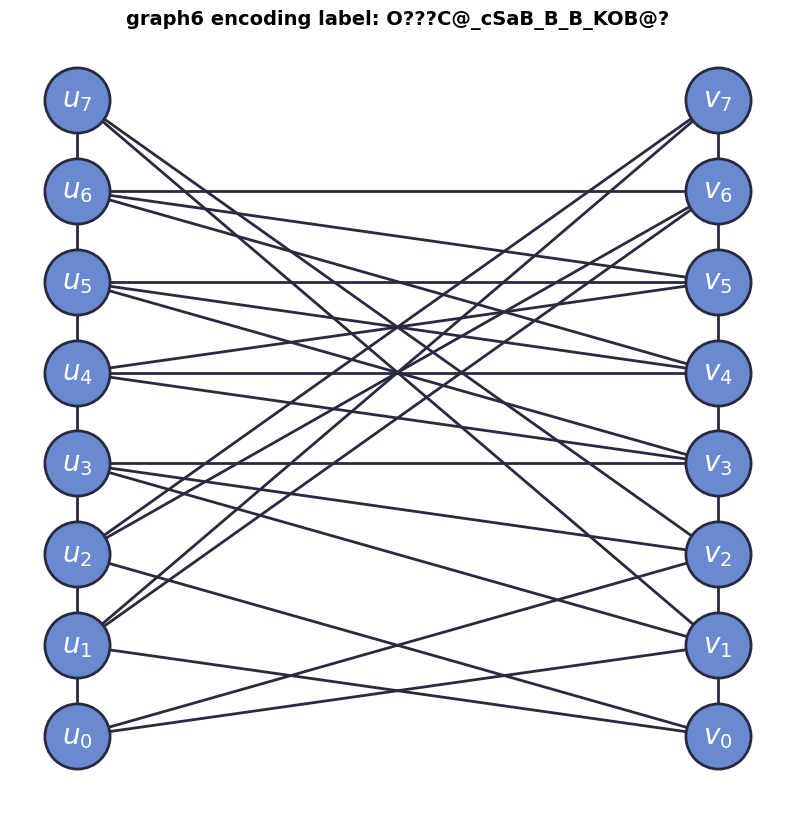

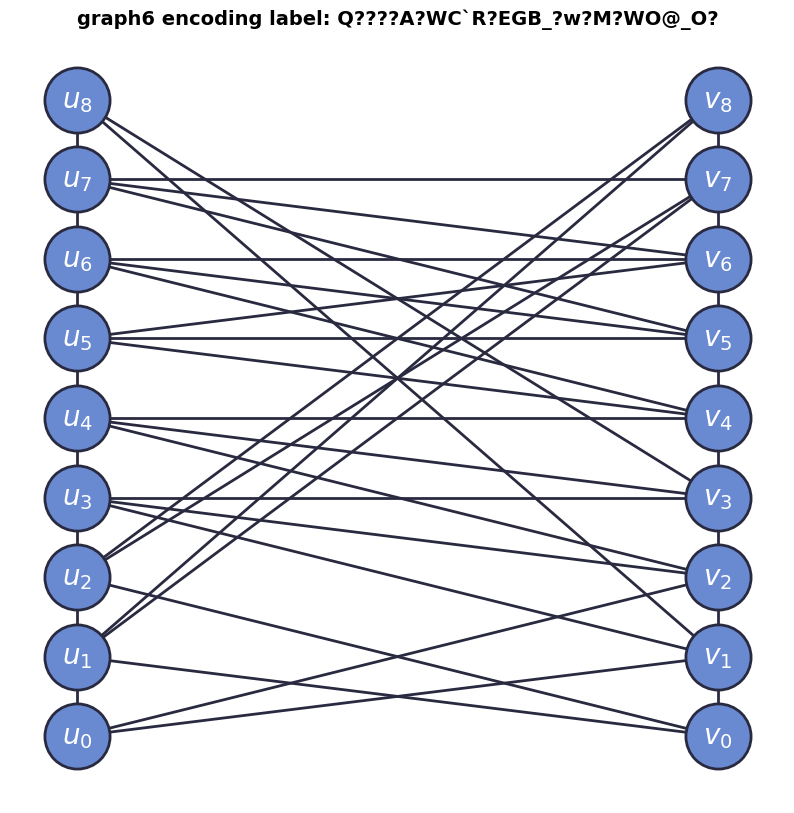

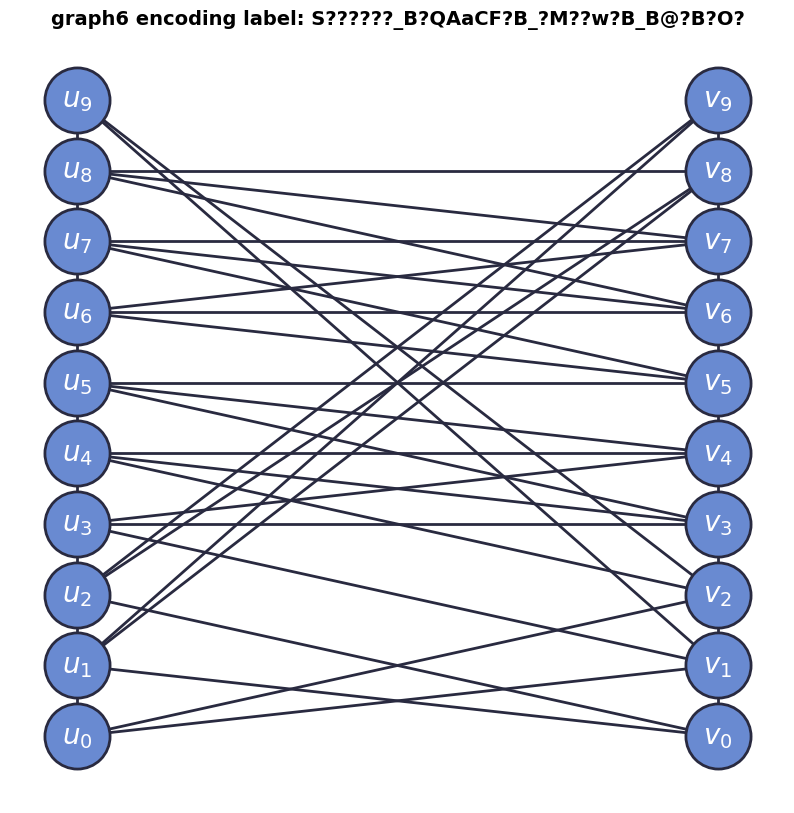

In [14]:

graphs = []
for g_str in extremal_cubic_graphs["graph6_encoding"]:
    decoded_graph = nx.from_graph6_bytes(g_str.encode())
    graphs.append(decoded_graph)

for graph in graphs:
    label = (
        nx.to_graph6_bytes(graph, header=False)
        .decode("utf-8")
        .replace("\n", "")
        .replace("\r", "")
    )
    
    n = graph.number_of_nodes()
    plt.figure(figsize=(10, 10))
    
    if nx.is_bipartite(graph):
        u_set, v_set = nx.bipartite.sets(graph)
        u_list, v_list = list(u_set), list(v_set)
    else:
        nodes = list(graph.nodes())
        u_list = nodes[:n//2]
        v_list = nodes[n//2:]

    pos = {}
    pos.update((node, (1, i)) for i, node in enumerate(u_list)) # Levi stolpec
    pos.update((node, (2, i)) for i, node in enumerate(v_list)) # Desni stolpec

    labels = {}
    for i, node in enumerate(u_list):
        labels[node] = f"$u_{{{i}}}$"
    for i, node in enumerate(v_list):
        labels[node] = f"$v_{{{i}}}$"

    nx.draw_networkx(
        graph,
        pos=pos,
        labels=labels,
        node_color="#698ad1",
        edgecolors="#292a40",
        linewidths=2,
        node_size=2200,
        width=2,
        edge_color="#292a40",
        font_color="white",
        font_size=20
    )

    plt.title(f"graph6 encoding label: {label}", fontweight="bold", fontsize=14)
    plt.axis("off")
    
    plt.savefig(f"../../docs/figs/opt_graphs/extremal_cubic_{n}.png", bbox_inches="tight", facecolor="white")
    plt.show()
